In [1]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/rtl.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))

# فصل ۵ — درخت‌های تصمیم و انواع آن
## درس ۱: مفهوم درخت‌های تصمیم

**دوره:** یادگیری ماشین مقدماتی + پیشرفته (مسیر داده‌های جدولی / روش‌های کلاسیک)

این نوت‌بوک یک درک «سرتاسری» از **درخت‌های تصمیم** می‌سازد: *کلاس مدل*، *الگوریتم القای حریصانه*، *معیارهای تقسیم*، و *کنترل‌های عملی* که یک درخت مفید را از یک درخت بیش‌برازش‌شده جدا می‌کنند.


### اهداف یادگیری
در پایان این درس می‌توانید:

1. توضیح دهید که درخت تصمیم چگونه به‌عنوان یک مدل **تقسیم‌بندی بازگشتی** (پیش‌بینی پله‌ای/تکه‌ای) کار می‌کند.
2. شرح دهید که درخت‌ها چگونه با یک رویه **حریصانه از بالا به پایین** ساخته می‌شوند.
3. معیارهای رایج تقسیم را محاسبه و تفسیر کنید: **جینی**، **آنتروپی/کسب اطلاعات** و **کاهش واریانس**.
4. پیچیدگی درخت را با محدودیت‌های عمق/برگ کنترل کنید و رفتار **بایاس–واریانس** را بفهمید.
5. با scikit-learn درخت‌های تصمیم را آموزش دهید و تفسیر کنید (استخراج قواعد و اهمیت ویژگی‌ها).
6. دام‌های رایج را تشخیص دهید: نشت داده، ناپایداری، و اهمیتِ گمراه‌کننده.

### پیش‌نیازها
- مبانی پایتون (NumPy/Pandas)
- مبانی یادگیری نظارت‌شده (تقسیم train/test، معیارها)
- نمادگذاری پایه‌ی احتمال


### مجموعه‌داده‌های استفاده‌شده در این درس (انتخاب تصادفی)
شما خواستید در درس‌های مختلف از مجموعه‌داده‌های متفاوت استفاده شود. برای *این* درس از **سه** مجموعه‌داده استفاده می‌کنیم:

- **طبقه‌بندی:** `iris.csv` (چندکلاسه و ساده)
- **رگرسیون:** `house-prices.csv` (رگرسیون جدولی)
- **نمونه‌ی ویژگی‌های دسته‌ای:** `drug200.csv` (پیش‌بین‌های دسته‌ای)

همه‌ی فایل‌ها با مسیرهای نسبی مخزن مثل `../../../Datasets/...` بارگذاری می‌شوند.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree, export_text
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## ۱. درخت تصمیم چیست؟

**درخت تصمیم** یک مدل یادگیری نظارت‌شده است که تابع پیش‌بینی را به صورت دنباله‌ای از آزمون‌های **اگر–آنگاه** روی ویژگی‌ها نمایش می‌دهد. به‌صورت مفهومی، یک درخت بارها فضای ورودی را به نواحی مختلف **تقسیم** می‌کند و در هر ناحیه یک پیش‌بینی ساده ارائه می‌دهد.

### ۱.۱ نگاه «تقسیم‌بندی بازگشتی»
فرض کنید فضای ویژگی‌ها $\mathcal{X}$ و هدف $y$ باشد. درخت یک افراز از $\mathcal{X}$ به ناحیه‌های $R_1, R_2, \dots, R_M$ می‌سازد که با تقسیم‌های محور‌محور (axis-aligned) مثل $x_j \le t$ تولید می‌شوند.

- **درخت رگرسیون** معمولاً میانگین هر ناحیه را پیش‌بینی می‌کند:

$$\hat{f}(x) = \sum_{m=1}^M \bar{y}_{R_m}\,\mathbf{1}[x\in R_m]$$

- **درخت طبقه‌بندی** معمولاً کلاسی را برمی‌گرداند که احتمال بیشتری در آن ناحیه دارد:

$$\hat{y}(x)=\arg\max_k\; \hat{p}_{mk} \quad \text{برای } x\in R_m$$

درخت‌ها **ناپارامتری** هستند: پیچیدگی‌شان با عمق و تعداد برگ‌ها رشد می‌کند، نه با تعداد پارامترهای ثابت.


### ۱.۲ چرا درخت‌ها مفیدند
- **تفسیرپذیری:** مسیر ریشه تا برگ یک قاعده‌ی قابل توضیح می‌سازد.
- **غیرخطی بودن:** درخت‌ها بدون مهندسی ویژگی هم می‌توانند برهم‌کنش‌های غیرخطی را مدل کنند.
- **ترکیب انواع داده:** می‌توانند ویژگی‌های عددی و (با کُدگذاری) ویژگی‌های دسته‌ای را استفاده کنند.
- **پیش‌پردازش کم:** معمولاً به مقیاس‌بندی نیاز ندارند؛ تبدیل‌های یکنواخت خیلی تأثیرگذار نیستند.

### ۱.۳ چرا درخت‌ها می‌توانند مشکل‌ساز باشند
- **واریانس بالا / ناپایداری:** تغییر کوچک در داده می‌تواند درخت کاملاً متفاوتی بسازد.
- **بیش‌برازش:** درخت‌های عمیق می‌توانند داده‌ی آموزشی را حفظ کنند.
- **سوگیری در اهمیت مبتنی بر ناخالصی:** ویژگی‌های با کاردینالیته‌ی بالا ممکن است بیش‌ازحد مهم به‌نظر برسند.


## ۲. درخت چگونه «تقسیم» را یاد می‌گیرد؟

یک درخت استاندارد با یک **رویه‌ی حریصانه از بالا به پایین** یاد گرفته می‌شود:

1. همه‌ی داده‌ها را در ریشه قرار دهید.
2. برای هر تقسیمِ کاندید، کاهش ناخالصی (در طبقه‌بندی) یا کاهش تابع زیان (در رگرسیون) را محاسبه کنید.
3. بهترین تقسیم را انتخاب کنید و روی فرزندها بازگشت (recursion) بزنید.
4. وقتی معیار توقف فعال شد متوقف شوید (عمق، حداقل نمونه، آستانه‌ی خلوص و ...).

این روش «حریصانه» است چون تقسیم را بر اساس بهبود محلی فوری انتخاب می‌کند، نه بر اساس بهینه‌سازی سراسری. بهینه‌سازی سراسری ساختار درخت معمولاً از نظر محاسباتی دشوار است؛ در عمل روش حریصانه استاندارد است.


### ۲.۱ معیارهای تقسیم (طبقه‌بندی)

فرض کنید یک گره شامل نمونه‌هایی با نسبت‌های کلاسی $p_1, \dots, p_K$ باشد.

- **ناخالصی جینی**:
$$G = 1 - \sum_{k=1}^K p_k^2$$

- **آنتروپی**:
$$H = -\sum_{k=1}^K p_k\log_2(p_k)$$

یک تقسیم، فرزند چپ و راست با ناخالصی‌های $I_L$ و $I_R$ و اندازه‌های $n_L$ و $n_R$ می‌سازد.
ناخالصی پس از تقسیم برابر میانگین وزن‌دار است:

$$I_{\text{after}} = \frac{n_L}{n} I_L + \frac{n_R}{n} I_R$$

**کسب (gain)** تعریف می‌شود:

$$\Delta I = I_{\text{before}} - I_{\text{after}}$$

بهترین تقسیم $\Delta I$ را بیشینه می‌کند.


### ۲.۲ معیارهای تقسیم (رگرسیون)

برای رگرسیون، یک هدف رایج کمینه کردن خطای مربعی است. در یک گره با اهداف $y_i$، بهترین پیش‌بینی ثابت میانگین $\bar{y}$ است. زیان گره را می‌توان به صورت مجموع مربع انحراف‌ها نوشت:

$$\text{SSE} = \sum_i (y_i - \bar{y})^2$$

تقسیم تلاش می‌کند با جدا کردن داده به فرزندها، **SSE را کاهش دهد**:

$$\Delta \text{SSE} = \text{SSE}_{\text{parent}} - (\text{SSE}_L + \text{SSE}_R)$$

کمینه کردن SSE بعد از تقسیم معادل بیشینه کردن $\Delta \text{SSE}$ است.


## ۳. بارگذاری مجموعه‌داده‌ها
سه مجموعه‌داده را از ساختار مخزن شما بارگذاری می‌کنیم.


In [3]:
iris_path = "../../../Datasets/Classification/iris.csv"
house_path = "../../../Datasets/Regression/house-prices.csv"
drug_path = "../../../Datasets/Classification/drug200.csv"

iris = pd.read_csv(iris_path)
house = pd.read_csv(house_path)
drug = pd.read_csv(drug_path)

display(iris.head())
display(house.head())
display(drug.head())

,sepal_length,sepal_width,petal_length,petal_width,classification
0,5.4,3.7,1.5,0.2,Iris-setosa
1,4.8,3.4,1.6,0.2,Iris-setosa
2,4.8,3.0,1.4,0.1,Iris-setosa
3,4.3,3.0,1.1,0.1,Iris-setosa
4,5.8,4.0,1.2,0.2,Iris-setosa


,Home,Price,SqFt,Bedrooms,Bathrooms,Offers,Brick,Neighborhood
0,1,114300,1790,2,2,2,No,East
1,2,114200,2030,4,2,3,No,East
2,3,114800,1740,3,2,1,No,East
3,4,94700,1980,3,2,3,No,East
4,5,119800,2130,3,3,3,No,East


,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


## ۴. توابع ناخالصی در پایتون
قبل از استفاده از scikit-learn، محاسبات اصلی ناخالصی را پیاده‌سازی می‌کنیم تا ببینیم درخت دقیقاً چه چیزی را بهینه می‌کند.


In [4]:
def gini_from_counts(counts: np.ndarray) -> float:
    counts = counts.astype(float)
    n = counts.sum()
    if n == 0:
        return 0.0
    p = counts / n
    return 1.0 - np.sum(p ** 2)

def entropy_from_counts(counts: np.ndarray) -> float:
    counts = counts.astype(float)
    n = counts.sum()
    if n == 0:
        return 0.0
    p = counts / n
    p = p[p > 0]
    return -np.sum(p * np.log2(p))

def impurity_gain(y: np.ndarray, left_mask: np.ndarray, criterion: str = "gini") -> float:
    # y: class labels
    y = np.asarray(y)
    left = y[left_mask]
    right = y[~left_mask]
    n = len(y)
    if n == 0 or len(left) == 0 or len(right) == 0:
        return 0.0

    def I(arr):
        counts = pd.Series(arr).value_counts().values
        if criterion == "gini":
            return gini_from_counts(counts)
        elif criterion == "entropy":
            return entropy_from_counts(counts)
        else:
            raise ValueError("criterion must be 'gini' or 'entropy'")

    I_parent = I(y)
    I_left = I(left)
    I_right = I(right)
    I_after = (len(left) / n) * I_left + (len(right) / n) * I_right
    return I_parent - I_after

# Demo on a simple threshold split for iris sepal_length
feature = "sepal_length"
threshold = iris[feature].median()
mask = iris[feature].values <= threshold
gain_gini = impurity_gain(iris["classification"].values, mask, "gini")
gain_ent = impurity_gain(iris["classification"].values, mask, "entropy")
gain_gini, gain_ent

(np.float64(0.17476190476190478), np.float64(0.4873894982207809))

## ۵. آموزش یک درخت طبقه‌بندی (Iris)

کارهایی که انجام می‌دهیم:
- تقسیم به train/test
- آموزش یک درخت تصمیم
- ارزیابی دقت و ماتریس درهم‌ریختگی
- نمایش گرافیکی درخت آموخته‌شده

حتی برای یک داده‌ی ساده، درختِ عمیق می‌تواند بیش‌برازش کند؛ کمی بعد این رفتار را بررسی می‌کنیم.


In [5]:
X = iris.drop(columns=["classification"]) 
y = iris["classification"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

clf = DecisionTreeClassifier(random_state=RANDOM_STATE)
clf.fit(X_train, y_train)

pred = clf.predict(X_test)
acc = accuracy_score(y_test, pred)
acc

0.8947368421052632

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        12
Iris-versicolor       0.80      0.92      0.86        13
 Iris-virginica       0.91      0.77      0.83        13

       accuracy                           0.89        38
      macro avg       0.90      0.90      0.90        38
   weighted avg       0.90      0.89      0.89        38



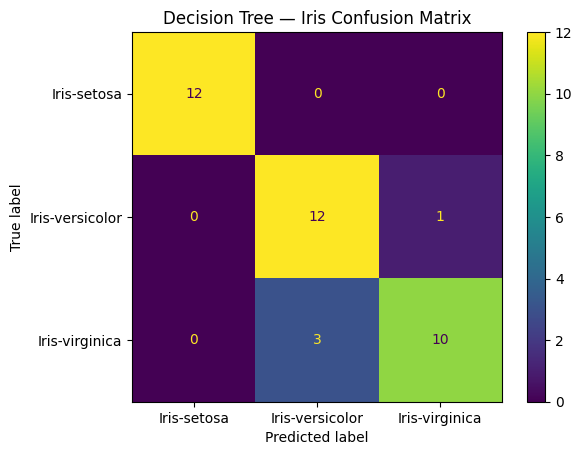

In [6]:
print(classification_report(y_test, pred))

disp = ConfusionMatrixDisplay.from_predictions(y_test, pred)
plt.title("Decision Tree — Iris Confusion Matrix")
plt.show()

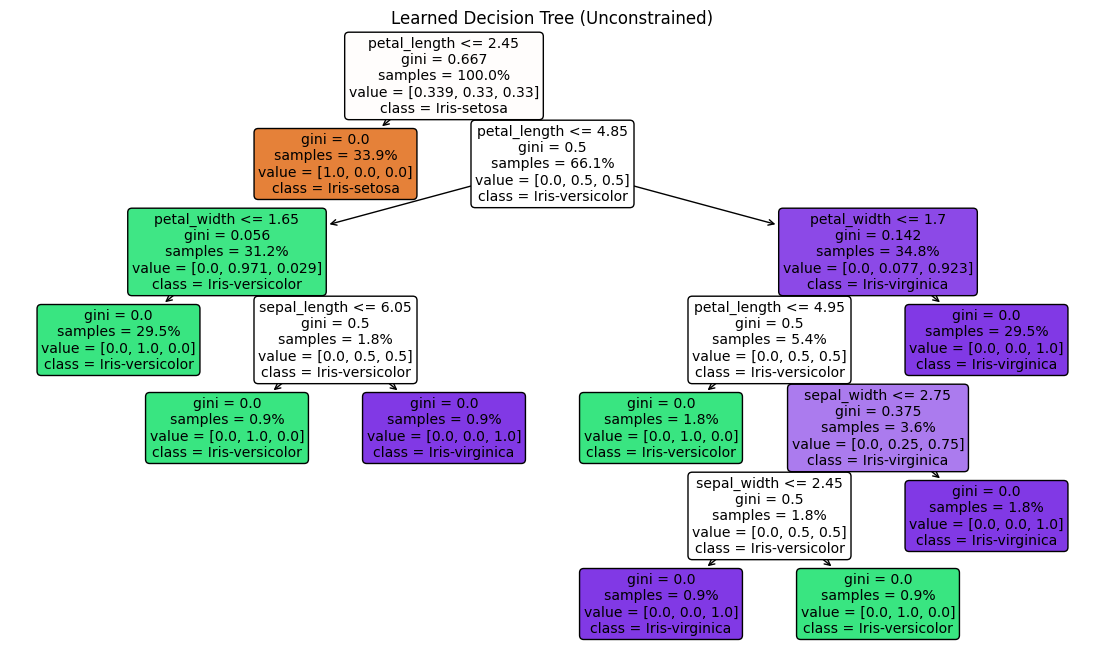

In [7]:
plt.figure(figsize=(14, 8))
plot_tree(
    clf,
    feature_names=X.columns,
    class_names=sorted(y.unique()),
    filled=True,
    impurity=True,
    proportion=True,
    rounded=True
)
plt.title("Learned Decision Tree (Unconstrained)")
plt.show()

### ۵.۱ تفسیرپذیری: قواعد به شکل متن
یکی از مزیت‌های کلیدی درخت‌ها این است که می‌توان آن‌ها را به قواعد قابل خواندن توسط انسان تبدیل کرد.


In [8]:
rules = export_text(clf, feature_names=list(X.columns))
print(rules[:2000])

|--- petal_length <= 2.45
|   |--- class: Iris-setosa
|--- petal_length >  2.45
|   |--- petal_length <= 4.85
|   |   |--- petal_width <= 1.65
|   |   |   |--- class: Iris-versicolor
|   |   |--- petal_width >  1.65
|   |   |   |--- sepal_length <= 6.05
|   |   |   |   |--- class: Iris-versicolor
|   |   |   |--- sepal_length >  6.05
|   |   |   |   |--- class: Iris-virginica
|   |--- petal_length >  4.85
|   |   |--- petal_width <= 1.70
|   |   |   |--- petal_length <= 4.95
|   |   |   |   |--- class: Iris-versicolor
|   |   |   |--- petal_length >  4.95
|   |   |   |   |--- sepal_width <= 2.75
|   |   |   |   |   |--- sepal_width <= 2.45
|   |   |   |   |   |   |--- class: Iris-virginica
|   |   |   |   |   |--- sepal_width >  2.45
|   |   |   |   |   |   |--- class: Iris-versicolor
|   |   |   |   |--- sepal_width >  2.75
|   |   |   |   |   |--- class: Iris-virginica
|   |   |--- petal_width >  1.70
|   |   |   |--- class: Iris-virginica



## ۶. رفتار بایاس–واریانس: عمق و بیش‌برازش

عمق درخت پیچیدگی را کنترل می‌کند:

- **درخت کم‌عمق**: بایاس بیشتر، واریانس کمتر.
- **درخت پرعمق**: بایاس کمتر، واریانس بیشتر.

در ادامه `max_depth` را تغییر می‌دهیم و دقت train و test را اندازه می‌گیریم.


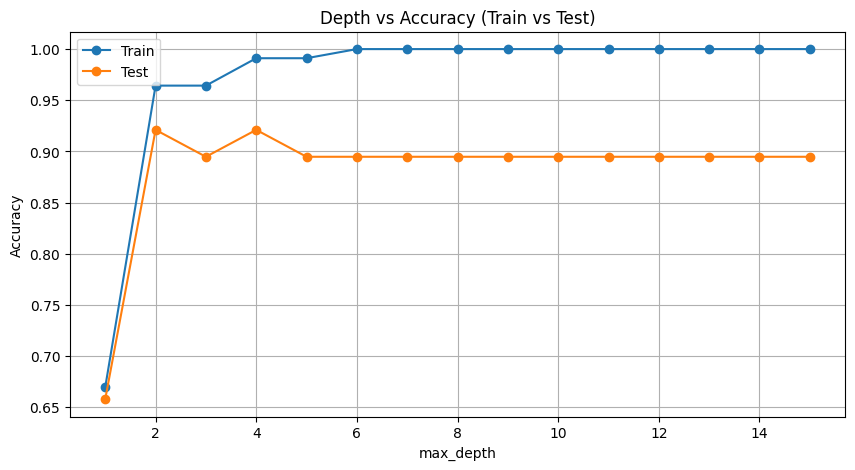

In [9]:
depths = list(range(1, 16))
train_acc = []
test_acc = []

for d in depths:
    model = DecisionTreeClassifier(max_depth=d, random_state=RANDOM_STATE)
    model.fit(X_train, y_train)
    train_acc.append(accuracy_score(y_train, model.predict(X_train)))
    test_acc.append(accuracy_score(y_test, model.predict(X_test)))

plt.figure(figsize=(10, 5))
plt.plot(depths, train_acc, marker='o')
plt.plot(depths, test_acc, marker='o')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Depth vs Accuracy (Train vs Test)')
plt.legend(['Train', 'Test'])
plt.grid(True)
plt.show()

### ۶.۱ اعتبارسنجی متقاطع برای انتخاب مقاوم
به جای یک تقسیم واحد، می‌توانیم از k-fold cross-validation استفاده کنیم تا تعمیم‌پذیری را بهتر برآورد کنیم.


In [10]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_scores = {}
for d in depths:
    model = DecisionTreeClassifier(max_depth=d, random_state=RANDOM_STATE)
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    cv_scores[d] = (scores.mean(), scores.std())

best_depth = max(cv_scores, key=lambda d: cv_scores[d][0])
best_depth, cv_scores[best_depth]

(3, (np.float64(0.96), np.float64(0.024944382578492935)))

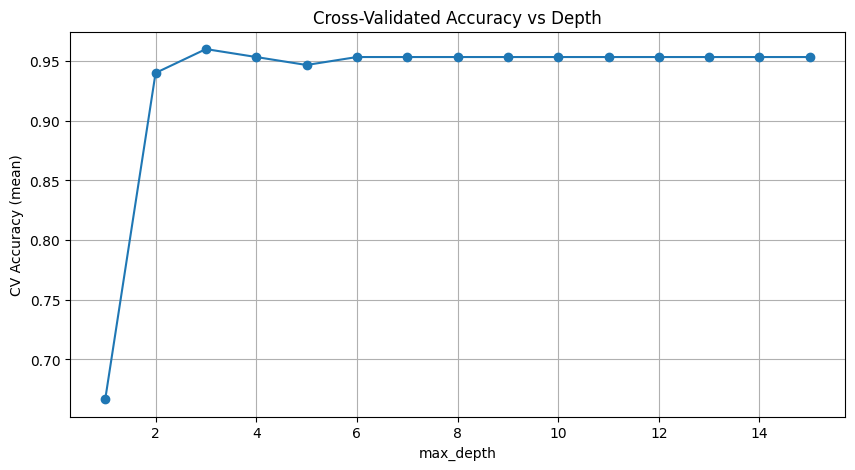

Best depth by CV: 3


In [11]:
means = [cv_scores[d][0] for d in depths]
stds = [cv_scores[d][1] for d in depths]

plt.figure(figsize=(10, 5))
plt.plot(depths, means, marker='o')
plt.xlabel('max_depth')
plt.ylabel('CV Accuracy (mean)')
plt.title('Cross-Validated Accuracy vs Depth')
plt.grid(True)
plt.show()

print('Best depth by CV:', best_depth)

## ۷. درخت‌های رگرسیون: یک رگرسور پله‌ای (House Prices)

درخت‌های رگرسیون از کاهش واریانس (یا کاهش خطای مربعی) استفاده می‌کنند. ما یک پایپ‌لاین می‌سازیم که ویژگی‌های دسته‌ای را با one-hot encoding مدیریت می‌کند.


In [12]:
target = "Price"
Xr = house.drop(columns=[target])
yr = house[target]

num_cols = [c for c in Xr.columns if Xr[c].dtype != 'object']
cat_cols = [c for c in Xr.columns if Xr[c].dtype == 'object']

preprocess = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ]
)

reg = DecisionTreeRegressor(random_state=RANDOM_STATE)
pipe = Pipeline(steps=[('preprocess', preprocess), ('model', reg)])

Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    Xr, yr, test_size=0.25, random_state=RANDOM_STATE
)

pipe.fit(Xr_train, yr_train)
pred_r = pipe.predict(Xr_test)

mae = mean_absolute_error(yr_test, pred_r)
rmse = mean_squared_error(yr_test, pred_r, squared=False)
mae, rmse

C:\Users\LENOVO.PIESC\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(np.float64(17053.125), np.float64(21018.71933539244))

### ۷.۱ نکته‌ی تفسیر برای درخت‌های رگرسیون
یک درخت رگرسیون پیش‌بینی‌های **پله‌ای** تولید می‌کند. این برای برخی مسائل تقریب خوبی است، اما برای روابط نرم/صاف ممکن است به برگ‌های زیاد نیاز داشته باشد و بیش‌برازش کند.


## ۸. مدیریت ویژگی‌های دسته‌ای (Drug200)

بسیاری از داده‌های واقعی ورودی‌های دسته‌ای دارند. یک روش استاندارد در scikit-learn این است:

- ستون‌های دسته‌ای را one-hot encode کنید
- درخت تصمیم را روی فضای ویژگیِ تبدیل‌شده آموزش دهید

نکته: با اینکه بعضی کتابخانه‌ها دسته‌ها را به‌صورت بومی پشتیبانی می‌کنند، درخت‌های کلاسیک scikit-learn معمولاً ویژگی‌های عددی انتظار دارند.


In [13]:
Xd = drug.drop(columns=["Drug"]) 
yd = drug["Drug"]

num_cols_d = [c for c in Xd.columns if Xd[c].dtype != 'object']
cat_cols_d = [c for c in Xd.columns if Xd[c].dtype == 'object']

preprocess_d = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_cols_d),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols_d),
    ]
)

clf_d = DecisionTreeClassifier(max_depth=4, random_state=RANDOM_STATE)
pipe_d = Pipeline(steps=[('preprocess', preprocess_d), ('model', clf_d)])

Xd_train, Xd_test, yd_train, yd_test = train_test_split(
    Xd, yd, test_size=0.25, random_state=RANDOM_STATE, stratify=yd
)

pipe_d.fit(Xd_train, yd_train)
pred_d = pipe_d.predict(Xd_test)
acc_d = accuracy_score(yd_test, pred_d)
acc_d

0.98

              precision    recall  f1-score   support

       DrugY       0.96      1.00      0.98        23
       drugA       1.00      1.00      1.00         6
       drugB       1.00      1.00      1.00         4
       drugC       1.00      1.00      1.00         4
       drugX       1.00      0.92      0.96        13

    accuracy                           0.98        50
   macro avg       0.99      0.98      0.99        50
weighted avg       0.98      0.98      0.98        50



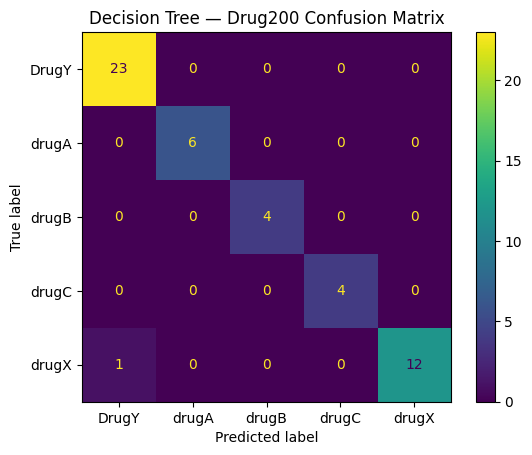

In [14]:
print(classification_report(yd_test, pred_d))

disp = ConfusionMatrixDisplay.from_predictions(yd_test, pred_d)
plt.title("Decision Tree — Drug200 Confusion Matrix")
plt.show()

## ۹. اهمیت ویژگی: چه معنایی دارد (و چه معنایی ندارد)

دو مفهوم رایج برای اهمیت:

1. **اهمیت مبتنی بر ناخالصی** (`feature_importances_`): جمع کاهش ناخالصی که هر ویژگی در تقسیم‌ها ایجاد می‌کند.
2. **اهمیت جایگشتی (Permutation)**: افت عملکرد وقتی مقادیر یک ویژگی را تصادفی جابه‌جا می‌کنیم.

اهمیت جایگشتی اغلب قابل اعتمادتر است، مخصوصاً وقتی ویژگی‌ها هم‌بسته هستند.


In [15]:
# We'll compute importances on the iris classifier
imp = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
imp

petal_length    0.919887
petal_width     0.046629
sepal_width     0.020091
sepal_length    0.013394
dtype: float64

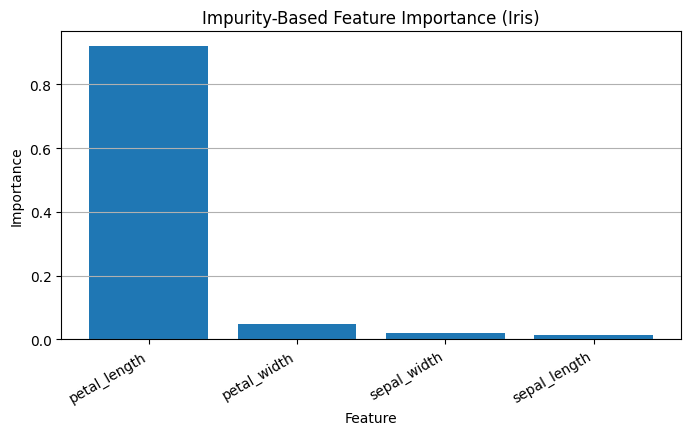

In [16]:
plt.figure(figsize=(8, 4))
plt.bar(imp.index, imp.values)
plt.title('Impurity-Based Feature Importance (Iris)')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=30, ha='right')
plt.grid(True, axis='y')
plt.show()

In [17]:
perm = permutation_importance(clf, X_test, y_test, n_repeats=25, random_state=RANDOM_STATE)
perm_imp = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=False)
perm_imp

petal_length    0.482105
petal_width     0.055789
sepal_length   -0.020000
sepal_width    -0.024211
dtype: float64

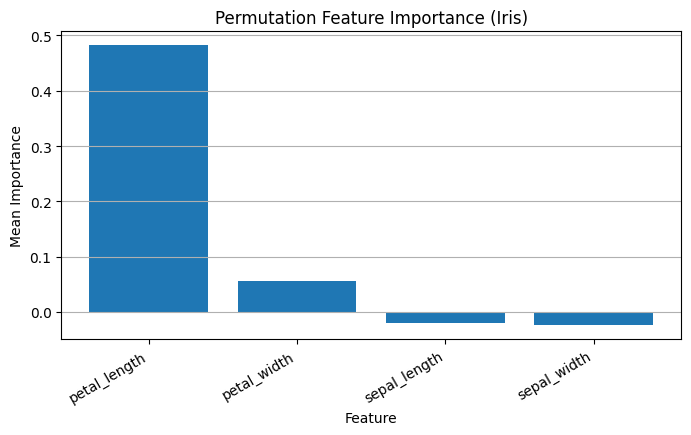

In [18]:
plt.figure(figsize=(8, 4))
plt.bar(perm_imp.index, perm_imp.values)
plt.title('Permutation Feature Importance (Iris)')
plt.xlabel('Feature')
plt.ylabel('Mean Importance')
plt.xticks(rotation=30, ha='right')
plt.grid(True, axis='y')
plt.show()

## ۱۰. نمایش ناپایداری: تغییر کوچک در داده، درخت متفاوت

درخت‌های تصمیم واریانس بالایی دارند. چندین درخت را روی bootstrap resampleها آموزش می‌دهیم و پیش‌بینی‌هایشان را روی یک مجموعه‌ی test ثابت مقایسه می‌کنیم.


In [19]:
def bootstrap_fit_predict(n_models=20):
    preds = []
    for i in range(n_models):
        idx = np.random.choice(len(X_train), size=len(X_train), replace=True)
        Xb = X_train.iloc[idx]
        yb = y_train.iloc[idx]
        m = DecisionTreeClassifier(max_depth=best_depth, random_state=RANDOM_STATE + i)
        m.fit(Xb, yb)
        preds.append(m.predict(X_test))
    return np.array(preds)

boot_preds = bootstrap_fit_predict(n_models=30)
variation_rate = (boot_preds != boot_preds[0]).mean()
variation_rate

np.float64(0.10263157894736842)

در مقدار `variation_rate` بالا، کسری از (مدل، نمونه)‌ها را می‌بینید که پیش‌بینی‌شان با مدل اول متفاوت است. مقادیر بزرگ‌تر یعنی ناپایداری بیشتر.


## ۱۱. از پیش‌بینی تا توضیح: مسیرهای تصمیم

برای یک نمونه‌ی خاص، می‌توانیم دنبال کنیم که از کدام گره‌ها عبور کرده است.


In [20]:
sample_idx = 0
x0 = X_test.iloc[[sample_idx]]
y0_true = y_test.iloc[sample_idx]
y0_pred = clf.predict(x0)[0]
y0_true, y0_pred

('Iris-setosa', 'Iris-setosa')

In [21]:
path = clf.decision_path(x0)
node_indices = path.indices
node_indices[:10], len(node_indices)

(array([0, 1], dtype=int32), 2)

In [22]:
print("Rules for this sample:\n")
print(export_text(clf, feature_names=list(X.columns)))

Rules for this sample:

|--- petal_length <= 2.45
|   |--- class: Iris-setosa
|--- petal_length >  2.45
|   |--- petal_length <= 4.85
|   |   |--- petal_width <= 1.65
|   |   |   |--- class: Iris-versicolor
|   |   |--- petal_width >  1.65
|   |   |   |--- sepal_length <= 6.05
|   |   |   |   |--- class: Iris-versicolor
|   |   |   |--- sepal_length >  6.05
|   |   |   |   |--- class: Iris-virginica
|   |--- petal_length >  4.85
|   |   |--- petal_width <= 1.70
|   |   |   |--- petal_length <= 4.95
|   |   |   |   |--- class: Iris-versicolor
|   |   |   |--- petal_length >  4.95
|   |   |   |   |--- sepal_width <= 2.75
|   |   |   |   |   |--- sepal_width <= 2.45
|   |   |   |   |   |   |--- class: Iris-virginica
|   |   |   |   |   |--- sepal_width >  2.45
|   |   |   |   |   |   |--- class: Iris-versicolor
|   |   |   |   |--- sepal_width >  2.75
|   |   |   |   |   |--- class: Iris-virginica
|   |   |--- petal_width >  1.70
|   |   |   |--- class: Iris-virginica



## ۱۲. کنترل‌های عملی (ابرپارامترها) که واقعاً مهم‌اند

کلیدهای کنترل پیچیدگی:

- `max_depth`: حداکثر عمق درخت.
- `min_samples_split`: حداقل تعداد نمونه برای تقسیم یک گره داخلی.
- `min_samples_leaf`: حداقل تعداد نمونه در یک برگ.
- `max_leaf_nodes`: سقف تعداد برگ‌ها.
- `ccp_alpha`: شدت pruning به روش cost-complexity (پس‌هرس).

مدل ذهنی مفید: این پارامترها بین **برازش** و **تعمیم** مبادله ایجاد می‌کنند.


### ۱۲.۱ pruning با cost-complexity (مفهوم)

CART یک تابع هدف هرس معرفی می‌کند:

$$\text{Cost}_\alpha(T) = \text{Impurity}(T) + \alpha\,|T|$$

که در آن $|T|$ تعداد برگ‌ها (جریمه‌ی پیچیدگی) و $\alpha\ge 0$ شدت هرس را تعیین می‌کند.
هرچه $\alpha$ بزرگ‌تر باشد معمولاً درخت کوچک‌تر می‌شود.


In [23]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas[:10], len(ccp_alphas)

(array([0.        , 0.00669643, 0.00867347, 0.01339286, 0.02266484,
        0.26355965, 0.33625638]),
 7)

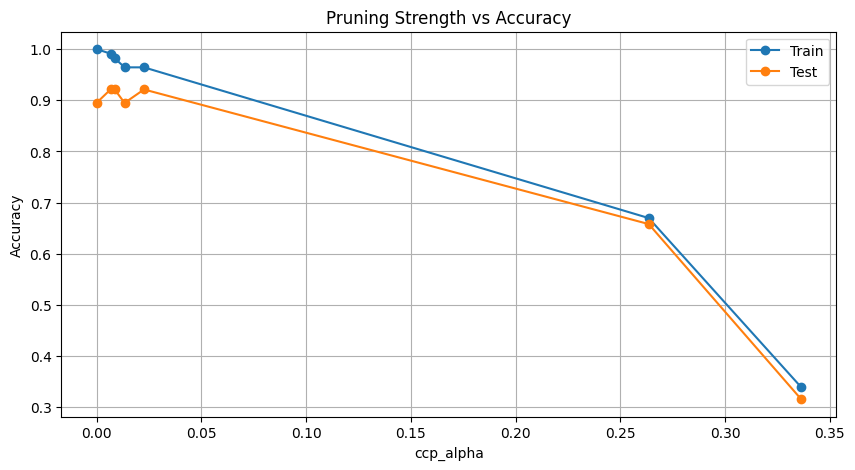

In [24]:
alphas = ccp_alphas[:: max(1, len(ccp_alphas)//15)]  # sample a subset for plotting
train_scores = []
test_scores = []

for a in alphas:
    m = DecisionTreeClassifier(random_state=RANDOM_STATE, ccp_alpha=float(a))
    m.fit(X_train, y_train)
    train_scores.append(accuracy_score(y_train, m.predict(X_train)))
    test_scores.append(accuracy_score(y_test, m.predict(X_test)))

plt.figure(figsize=(10, 5))
plt.plot(alphas, train_scores, marker='o')
plt.plot(alphas, test_scores, marker='o')
plt.xlabel('ccp_alpha')
plt.ylabel('Accuracy')
plt.title('Pruning Strength vs Accuracy')
plt.legend(['Train', 'Test'])
plt.grid(True)
plt.show()

## ۱۳. یک درخت تصمیم مینیمال از صفر (آموزشی)

برای شفاف شدن سازوکار القای درخت، یک پیاده‌سازی کوچک ارائه شده که:

- از **ناخالصی جینی** استفاده می‌کند
- روی هر ویژگی عددی آستانه‌ها را جستجو می‌کند
- یک درخت دودویی تا عمق `max_depth` می‌سازد

این کد بهینه‌سازی نشده و صرفاً برای یادگیری است.


In [25]:
from dataclasses import dataclass
from typing import Optional, Tuple

@dataclass
class Node:
    feature: Optional[int] = None
    threshold: Optional[float] = None
    left: Optional['Node'] = None
    right: Optional['Node'] = None
    prediction: Optional[int] = None  # class index at leaf

def gini(y_int: np.ndarray, n_classes: int) -> float:
    counts = np.bincount(y_int, minlength=n_classes)
    return gini_from_counts(counts)

def best_split(Xn: np.ndarray, y_int: np.ndarray, n_classes: int) -> Tuple[float, Optional[int], Optional[float]]:
    n, d = Xn.shape
    base = gini(y_int, n_classes)
    best_gain = 0.0
    best_j = None
    best_t = None
    for j in range(d):
        values = Xn[:, j]
        thresholds = np.unique(values)
        if len(thresholds) <= 1:
            continue
        # candidate thresholds: midpoints between sorted unique values
        thresholds = (thresholds[:-1] + thresholds[1:]) / 2.0
        for t in thresholds:
            mask = values <= t
            if mask.sum() == 0 or mask.sum() == n:
                continue
            left_y = y_int[mask]
            right_y = y_int[~mask]
            after = (len(left_y)/n)*gini(left_y, n_classes) + (len(right_y)/n)*gini(right_y, n_classes)
            gain = base - after
            if gain > best_gain:
                best_gain, best_j, best_t = gain, j, float(t)
    return best_gain, best_j, best_t

def build_tree(Xn: np.ndarray, y_int: np.ndarray, n_classes: int, depth: int, max_depth: int, min_leaf: int) -> Node:
    node = Node()
    # majority class
    node.prediction = int(np.argmax(np.bincount(y_int, minlength=n_classes)))
    # stopping
    if depth >= max_depth or len(y_int) <= 2*min_leaf or gini(y_int, n_classes) == 0.0:
        return node
    gain, j, t = best_split(Xn, y_int, n_classes)
    if j is None or gain <= 1e-12:
        return node
    mask = Xn[:, j] <= t
    if mask.sum() < min_leaf or (~mask).sum() < min_leaf:
        return node
    node.feature = j
    node.threshold = t
    node.left = build_tree(Xn[mask], y_int[mask], n_classes, depth+1, max_depth, min_leaf)
    node.right = build_tree(Xn[~mask], y_int[~mask], n_classes, depth+1, max_depth, min_leaf)
    return node

def predict_one(node: Node, x: np.ndarray) -> int:
    while node.feature is not None and node.left is not None and node.right is not None:
        if x[node.feature] <= node.threshold:
            node = node.left
        else:
            node = node.right
    return int(node.prediction)

# Train scratch tree on iris (numeric-only)
Xn = X.values.astype(float)
classes = sorted(y.unique())
class_to_int = {c:i for i,c in enumerate(classes)}
y_int = y.map(class_to_int).values

Xn_tr, Xn_te, y_tr, y_te = train_test_split(Xn, y_int, test_size=0.25, random_state=RANDOM_STATE, stratify=y_int)
scratch = build_tree(Xn_tr, y_tr, n_classes=len(classes), depth=0, max_depth=4, min_leaf=3)
pred_int = np.array([predict_one(scratch, xi) for xi in Xn_te])
scratch_acc = (pred_int == y_te).mean()
scratch_acc

np.float64(0.9210526315789473)

این پیاده‌سازی از صفر عمداً ساده است و بسیاری از امکاناتِ سطح تولید را ندارد (مدیریت مقادیر گمشده، pruning، قوانین شکست تساوی، بهینه‌سازی کارایی). اما ایده‌ی اصلی را دقیق نشان می‌دهد: **تقسیمی را انتخاب کن که ناخالصی را بیشترین مقدار کاهش می‌دهد** و بازگشت انجام بده.


## ۱۴. تمرین‌ها (همراه با پاسخ)

این تمرین‌ها را انجام دهید تا هم شهود و هم مهارت عملی‌تان تقویت شود.

### تمرین ۱ — محاسبه‌ی دستی ناخالصی
یک گره با شمارش کلاس‌ها `[10, 10, 0]` و یک گره با شمارش `[18, 1, 1]` را در نظر بگیرید. جینی و آنتروپی را حساب کنید. کدام گره «خالص‌تر» است؟

### تمرین ۲ — تنظیم عمق
با Iris، `max_depth` را sweep کنید و بهترین مقدار را با ۵-fold cross-validation پیدا کنید.

### تمرین ۳ — هرس (Pruning)
با `cost_complexity_pruning_path` مقادیر کاندید `ccp_alpha` را بسازید، سپس مقداری را انتخاب کنید که دقت تست را بیشینه کند.

### تمرین ۴ — حساسیت درخت رگرسیون
روی House Prices، درخت‌های رگرسیون با `max_depth=2, 4, 8` را مقایسه کنید. MAE/RMSE را گزارش کنید.

### تمرین ۵ — نکته‌ی اهمیت جایگشتی
یک ویژگی تکراری به Iris اضافه کنید (کپی یک ستون) و ببینید اهمیت مبتنی بر ناخالصی در مقایسه با اهمیت جایگشتی چه رفتاری دارد.


In [26]:
# Solutions

# Exercise 1
counts1 = np.array([10, 10, 0])
counts2 = np.array([18, 1, 1])
print('Node A Gini:', gini_from_counts(counts1), 'Entropy:', entropy_from_counts(counts1))
print('Node B Gini:', gini_from_counts(counts2), 'Entropy:', entropy_from_counts(counts2))

# Exercise 2
best_depth2 = best_depth
print('Best depth (from earlier CV):', best_depth2)

# Exercise 3 (simple search over alphas from pruning path)
path2 = clf.cost_complexity_pruning_path(X_train, y_train)
alphas2 = path2.ccp_alphas
best_a = 0.0
best_acc = -1.0
for a in alphas2:
    m = DecisionTreeClassifier(random_state=RANDOM_STATE, ccp_alpha=float(a))
    m.fit(X_train, y_train)
    a_acc = accuracy_score(y_test, m.predict(X_test))
    if a_acc > best_acc:
        best_acc = a_acc
        best_a = float(a)
print('Best ccp_alpha:', best_a, 'Test accuracy:', best_acc)

# Exercise 4
for d in [2, 4, 8]:
    reg2 = DecisionTreeRegressor(max_depth=d, random_state=RANDOM_STATE)
    pipe2 = Pipeline(steps=[('preprocess', preprocess), ('model', reg2)])
    pipe2.fit(Xr_train, yr_train)
    pr = pipe2.predict(Xr_test)
    mae2 = mean_absolute_error(yr_test, pr)
    rmse2 = mean_squared_error(yr_test, pr, squared=False)
    print('max_depth=', d, 'MAE=', mae2, 'RMSE=', rmse2)

# Exercise 5
X_dup = X.copy()
X_dup['sepal_length_dup'] = X_dup['sepal_length']
Xd_tr, Xd_te, yd_tr2, yd_te2 = train_test_split(X_dup, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)
clf_dup = DecisionTreeClassifier(random_state=RANDOM_STATE)
clf_dup.fit(Xd_tr, yd_tr2)
imp_dup = pd.Series(clf_dup.feature_importances_, index=X_dup.columns).sort_values(ascending=False)
perm_dup = permutation_importance(clf_dup, Xd_te, yd_te2, n_repeats=25, random_state=RANDOM_STATE)
perm_dup_s = pd.Series(perm_dup.importances_mean, index=X_dup.columns).sort_values(ascending=False)
display(pd.DataFrame({'impurity_importance': imp_dup, 'permutation_importance': perm_dup_s}).fillna(0))

Node A Gini: 0.5 Entropy: 1.0
Node B Gini: 0.18500000000000005 Entropy: 0.5689955935892812
Best depth (from earlier CV): 3
Best ccp_alpha: 0.006696428571428571 Test accuracy: 0.9210526315789473
max_depth= 2 MAE= 12302.618902439026 RMSE= 15721.038090289903
max_depth= 4 MAE= 10567.71543560606 RMSE= 14752.663267815893
max_depth= 8 MAE= 16535.267857142855 RMSE= 20845.960646012503


C:\Users\LENOVO.PIESC\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\LENOVO.PIESC\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\LENOVO.PIESC\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,impurity_importance,permutation_importance
petal_length,0.428856,0.083158
petal_width,0.551053,0.545263
sepal_length,0.006697,-0.007368
sepal_length_dup,0.000000,0.000000
sepal_width,0.013394,0.018947


## ۱۵. جمع‌بندی

- درخت تصمیم فضای ویژگی را به نواحی تقسیم می‌کند و برای هر ناحیه یک برچسب/مقدار ثابت پیش‌بینی می‌کند.
- درخت‌ها به‌صورت حریصانه با بیشینه کردن کاهش ناخالصی/زیان در هر تقسیم ساخته می‌شوند.
- عمق و محدودیت‌های برگ، مبادله‌ی بایاس–واریانس را کنترل می‌کند.
- درخت‌ها تفسیرپذیرند، اما می‌توانند ناپایدار و مستعد بیش‌برازش باشند.
- اهمیت ویژگی باید با احتیاط تفسیر شود؛ اهمیت جایگشتی اغلب قابل اعتمادتر است.

در درس‌های بعدی، **CART** را دقیق‌تر رسمی می‌کنیم، درباره‌ی **pruning** صحبت می‌کنیم و سپس درخت‌ها را به **ensemble**‌ها تعمیم می‌دهیم.
